In [1]:
from __future__ import division
import imp
import uproot
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import ROOT
import time
import math
helper = imp.load_source('helpfunction','/home/tmettler/Desktop/uBoone/do_plots/helpfunction.py')
globale = imp.load_source('globale','/home/tmettler/Desktop/uBoone/do_plots/globale.py')
#import /home/tmettler/Desktop/uBoone/do_plots/helpfunction as helper
import collections
NuCC = imp.load_source('NuCC_function','/home/tmettler/Desktop/uBoone/do_plots/NuCC_function.py')
NuCC_w = imp.load_source('NuCCWeight_function','/home/tmettler/Desktop/uBoone/do_plots/NuCCWeight_function.py')

Welcome to JupyROOT 6.10/08


In [2]:
#!jupyter nbconvert --to script numuCCana_muon_cut_V33.ipynb

In [3]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


# CRTinBNB tagger, Overlay or MC

In [4]:
# Load input files
#inputdir = '/home/thomasm/numuCC/V33/10kevents/'
inputdir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
outputdir = inputdir+'muon_cut/' 
outputdir_png, outputdir_root = NuCC.prepareOutput(outputdir)

#filename_overlay = 'NuCCana_Overlay_V18_V4.root'
filename_overlay = 'NuCCana_overlay_V26_weight.root'
#filename_overlay = 'NuCCana_overlay_v25_weighted_all.root'
filename_data = 'NuCCana_data_V22.root'
filename_ext = 'NuCCana_ext_V25.root'
filename_dirt = 'NuCCana_dirt_V26_weight.root'
    
tree_name = 'numuCCAna'

In [5]:
#Open all the trees of the four files (data, ext, dirt, overlay)
data, ext, dirt, overlay = NuCC.openTrees(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
NuCC.printNumberOfEntries(data,ext,dirt,overlay)

pot_overlay = NuCC.getPOT(inputdir,filename_overlay,tree_name)
pot_dirt =  NuCC.getPOT(inputdir,filename_dirt,tree_name)

#V25 files
pot_data =     8.649e+18  # best with tor875
data_trigger = 1854495.0 #4743794 # 1987072.0 # E1DCNT_wcut
ext_trigger =  18997529.0  #2120135 #5685315 # EXT

print 'POT: '
print 'Data:\t\t', pot_data
print 'Ext:\t\t', 0
print 'Overlay:\t', pot_overlay
print 'Dirt:\t\t', pot_dirt
print ''
pot_overlay = pot_overlay
sample = [data,ext,overlay,dirt]
scale = {data:1.0,ext:1.0,overlay:1.0,dirt:1.0}
name = {data:'data',ext:'ext',overlay:'overlay',dirt:'dirt'}
scale[data], scale[ext], scale[dirt], scale[overlay] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)
scale[dirt] = scale[dirt]
scale[overlay] = scale[overlay]
print 'Scalefactors: '
print 'Data:\t\t', scale[data]
print 'Ext:\t\t', scale[ext]
print 'Overlay:\t', scale[overlay]
print 'Dirt:\t\t', scale[dirt]


Overlay: Number of Entries:	989745
Data: Number of Entries:	33178
Ext: Number of Entries:		222702
Dirt: Number of Entries:	40808

POT: 
Data:		8.649e+18
Ext:		0
Overlay:	1.24025430537e+21
Dirt:		1.25019694173e+20

Scalefactors: 
Data:		1.0
Ext:		0.0976176954382
Overlay:	0.00697356982562
Dirt:		0.0691811002835


Warning in <TClass::Init>: no dictionary for class ROOT::TIOFeatures is available


In [6]:
if 1:
    filename_overlay = filename_overlay+'out33wG.root'
    #filename_overlay = 'NuCCana_overlay_points_1kev.rootout2.root'
    filename_data = filename_data+'out33.root'
    filename_ext = filename_ext+'out33.root'
    filename_dirt = filename_dirt+'out33.root'

    tree_name = 't_out'

    data_out, ext_out, dirt_out, overlay_out = NuCC.openTreesOut(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
    NuCC.printNumberOfEntries(data_out,ext_out,dirt_out,overlay_out)

    sample_out = [data_out,ext_out,overlay_out,dirt_out]
    scale_out = {data_out:1.0,ext_out:1.0,overlay_out:1.0,dirt_out:1.0}
    name_out = {data_out:'data',ext_out:'ext',overlay_out:'overlay',dirt_out:'dirt'}

    scale_out[data_out], scale_out[ext_out], scale_out[dirt_out], scale_out[overlay_out] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)
    scale_out[dirt_out] = scale_out[dirt_out]
    scale_out[overlay_out] = scale_out[overlay_out]

Overlay: Number of Entries:	989714
Data: Number of Entries:	33177
Ext: Number of Entries:		222701
Dirt: Number of Entries:	40807



In [7]:
# Define signals

fidVol = '(Nu_Vx_sce>(-1.55+10) && Nu_Vx_sce<(254.8-10)) && (Nu_Vy_sce>(-115.53+10) && Nu_Vy_sce<(117.47-10)) &&(Nu_Vz_sce>(-0.1+10) && Nu_Vz_sce<(1036.9-50))'
MCfidVol = '(MCNu_Vx>(-1.55+10) && MCNu_Vx<(254.8-10)) && (MCNu_Vy>(-115.53+10) && MCNu_Vy<(117.47-10)) &&(MCNu_Vz>(-0.1+10) && MCNu_Vz<(1036.9-50))'
numu_true = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14' # numu true CC signal definition

#numu_signal = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG==13 && MCTrackPurity>0.5' # numu CC signal definition
numu_signal_QE = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG==13 && MCTrackPurity>0.5 && MCNu_Interaction==0' # numu CC signal definition
numu_signal_RES = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG==13 && MCTrackPurity>0.5 && MCNu_Interaction==1' # numu CC signal definition
numu_signal_DIS = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG==13 && MCTrackPurity>0.5 && MCNu_Interaction==2' # numu CC signal definition
numu_signal_Coh = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG==13 && MCTrackPurity>0.5 && MCNu_Interaction==3' # numu CC signal definition
numu_signal_MEC = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG==13 && MCTrackPurity>0.5 && MCNu_Interaction==10' # numu CC signal definition
numu_bkg = 'fidVol && !(MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG==13 && MCTrackPurity>0.5)' # not an MC muon

#signal = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14'
for x in sample:
    x.SetAlias('muon','(muon_candidate_key==track_key)')
    #x.SetAlias('muon','(track_key == key_muon)')
    
num_fidVol = {}
for x in sample:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('CC_QE',numu_signal_QE)
    x.SetAlias('CC_RES',numu_signal_RES)
    x.SetAlias('CC_DIS',numu_signal_DIS)
    x.SetAlias('CC_Coh',numu_signal_Coh)
    x.SetAlias('CC_MEC',numu_signal_MEC)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('bkg',numu_bkg)
    #x.SetAlias('numu_lowpur',numu_lowpur)
    #x.SetAlias('numu_nc',numu_nc)
    #x.SetAlias('numu_ov',numu_ov)
    #x.SetAlias('numu_other',numu_other)
    num_fidVol[x] = x.GetEntries('fidVol && muon')*scale[x]
    
tot_num_fidVol = num_fidVol[ext]+num_fidVol[dirt]+num_fidVol[overlay]
overlay_signals = {'CC_QE','CC_RES','CC_DIS','CC_Coh','CC_MEC','bkg'}

In [8]:
for x in sample_out:
    x.SetAlias('muon','(track_key == key_muon)')
    #x.SetAlias('muon','(key_muprotratio==track_key)')
    
num_fidVol = {}
for x in sample_out:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('CC_QE',numu_signal_QE)
    x.SetAlias('CC_RES',numu_signal_RES)
    x.SetAlias('CC_DIS',numu_signal_DIS)
    x.SetAlias('CC_Coh',numu_signal_Coh)
    x.SetAlias('CC_MEC',numu_signal_MEC)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('bkg',numu_bkg)
    #x.SetAlias('numu_lowpur',numu_lowpur)
    #x.SetAlias('numu_nc',numu_nc)
    #x.SetAlias('numu_ov',numu_ov)
    #x.SetAlias('numu_other',numu_other)


In [9]:
# Load the global variables for access of functions
NuCC.loadGlobal(data,ext,dirt,overlay,data_out,ext_out,dirt_out,overlay_out,scale,scale_out,tot_num_fidVol,overlay_signals,sample,sample_out, name,name_out, outputdir_png, outputdir_root)
#NuCC.printGlobal()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [10]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",400,300)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

In [11]:
track_start_border_x = '(TrackStart_x_sce <(-1.55+1) || TrackStart_x_sce > (254.8-1))'
track_end_border_x = '(TrackEnd_x_sce <(-1.55+1) || TrackEnd_x_sce > (254.8-1))'
track_start_border_y = '(TrackStart_y_sce <(-115.53+1) || TrackStart_y_sce > (117.47-1))'
track_end_border_y = '(TrackEnd_y_sce <(-115.53+1) || TrackEnd_y_sce > (117.47-1))'
track_start_border_z = '(TrackStart_z_sce <(0.1+1) || TrackStart_z_sce > (1036.9-1))'
track_end_border_z = '(TrackEnd_z_sce <(0.1+1) || TrackEnd_z_sce > (1039.9-1))'

track_end_uncontained = '(' + track_end_border_x + ' || ' + track_end_border_y + ' || ' + track_end_border_z+ ')'


data.SetAlias("track_end_uncontained",track_end_uncontained)
ext.SetAlias("track_end_uncontained",track_end_uncontained)
overlay.SetAlias("track_end_uncontained",track_end_uncontained)
dirt.SetAlias("track_end_uncontained",track_end_uncontained)
data_out.SetAlias("track_end_uncontained",track_end_uncontained)
ext_out.SetAlias("track_end_uncontained",track_end_uncontained)
overlay_out.SetAlias("track_end_uncontained",track_end_uncontained)
dirt_out.SetAlias("track_end_uncontained",track_end_uncontained)

data.SetAlias("crt_cut","(abs(crtt0_time-(69000-crt_trig_corr_med)/1000-4)<0.8 || crtt0_time==-1)")
ext.SetAlias("crt_cut","(abs(crtt0_time-(69000-crt_trig_corr_med)/1000-3.57+3.195-4)<0.8 || crtt0_time==-1)")
overlay.SetAlias("crt_cut","(abs(crtt0_time-4)<0.8 || crtt0_time==-1)")
dirt.SetAlias("crt_cut","(abs(crtt0_time-4)<0.8 || crtt0_time==-1)")
data_out.SetAlias("crt_cut","(abs(crtt0_time-(69000-crt_trig_corr_med)/1000-4)<0.8 || crtt0_time==-1)")
ext_out.SetAlias("crt_cut","(abs(crtt0_time-(69000-crt_trig_corr_med)/1000-3.57+3.195-4)<0.8 || crtt0_time==-1)")
overlay_out.SetAlias("crt_cut","(abs(crtt0_time-4)<0.8 || crtt0_time==-1)")
dirt_out.SetAlias("crt_cut","(abs(crtt0_time-4)<0.8 || crtt0_time==-1)")

crt_tom_cut = 'nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut'

data.SetAlias("crt_tom_cut",crt_tom_cut)
ext.SetAlias("crt_tom_cut",crt_tom_cut)
overlay.SetAlias("crt_tom_cut",crt_tom_cut)
dirt.SetAlias("crt_tom_cut",crt_tom_cut)
data_out.SetAlias("crt_tom_cut",crt_tom_cut)
ext_out.SetAlias("crt_tom_cut",crt_tom_cut)
overlay_out.SetAlias("crt_tom_cut",crt_tom_cut)
dirt_out.SetAlias("crt_tom_cut",crt_tom_cut)

p_para = 'sqrt(TrackDir_x*TrackDir_x+TrackDir_y*TrackDir_y)*TrackMomMCS_mom'

data.SetAlias("p_para",p_para)
ext.SetAlias("p_para",p_para)
overlay.SetAlias("p_para",p_para)
dirt.SetAlias("p_para",p_para)
data_out.SetAlias("p_para",p_para)
ext_out.SetAlias("p_para",p_para)
overlay_out.SetAlias("p_para",p_para)
dirt_out.SetAlias("p_para",p_para)


p_per = 'TrackDir_z*TrackMomMCS_mom'

data.SetAlias("p_per",p_per)
ext.SetAlias("p_per",p_per)
overlay.SetAlias("p_per",p_per)
dirt.SetAlias("p_per",p_per)
data_out.SetAlias("p_per",p_per)
ext_out.SetAlias("p_per",p_per)
overlay_out.SetAlias("p_per",p_per)
dirt_out.SetAlias("p_per",p_per)


True

In [12]:
def make_true_histo_weight(cut,variable,weight,title,xstart,xend,xbins,file_name,side='right'):
    #initialize the 1d histograms
    weight_name = 'EventWeight*TunedCentralValue_Genie'
    h_data_func = ROOT.TH1F("h_data_func",title,xbins,xstart,xend)
    h_ext_func = ROOT.TH1F("h_ext_func",title,xbins,xstart,xend)
    h_dirt_func = ROOT.TH1F("h_dirt_func",title,xbins,xstart,xend)
    h_overlay_func = {} # make an array of histograms for the different interactions
    for x in globale.overlay_signals:
        h_overlay_func[x] = ROOT.TH1F(x,title,xbins,xstart,xend)
    #variable = variable
    # Draw/Fill the histograms for all kind of interactions
    globale.data_out.Draw(variable+'>>h_data_func',cut,'')
    globale.ext_out.Draw(variable+'>>h_ext_func',cut,'')
    #mofify this...
    globale.dirt_out.Draw(variable+'>>h_dirt_func',weight_name+'*('+cut+')','')

    cut = cut +' && '
    for x in globale.overlay_signals:
        histo = x
        globale.overlay_out.Draw(variable+'>>'+histo,weight_name+'*('+cut+x+')','')
        #h_overlay_func[x] = fill_histo(globale.overlay_out,variable,h_overlay_func[x],cut+x)
    # prepare the stacked histogram
    hs = ROOT.TH1F("hs",title,xbins,xstart,xend)
    h_ext_func.SetFillColor(2)
    h_ext_func.SetLineColor(1)
    h_dirt_func.SetFillColor(42)
    h_dirt_func.SetLineColor(1)
    h_data_func.SetLineWidth(1)
    #scale the histograms
    h_data_func.Sumw2()	
    h_data_func.Scale(globale.scale[globale.data])
    h_ext_func.Sumw2()	
    h_ext_func.Scale(globale.scale[globale.ext])
    h_dirt_func.Sumw2()	
    h_dirt_func.Scale(globale.scale[globale.dirt])
    
    h_data_func.Add(h_ext_func,-1)
    h_data_func.Add(h_dirt_func,-1)
    
    #fill the stacked histogram
    #hs.Add(h_ext_func)
    #hs.Add(h_dirt_func)
    mc_events = 0
    mc_event_list = {}
    for i,x in enumerate(globale.overlay_signals):
        #h_overlay_func[x].Sumw2()
        h_overlay_func[x].Scale(globale.scale[globale.overlay])
        #h_overlay_func[x].SetFillColor((2*i+11))
        h_overlay_func[x].SetLineColor((1*(i+1)))
        h_overlay_func[x].SetLineWidth(2)
        #h_overlay_func[x].SetLineColor(1)
        mc_event_list[x] = h_overlay_func[x].GetSumOfWeights()
        if x!= 'bkg':
            mc_events = mc_events+mc_event_list[x]
            hs.Add(h_overlay_func[x])
    # calculate the data - MC ratio
    h_data_func.Add(h_overlay_func['bkg'],-1)
    #mc_events = mc_events-mc_event_list['bkg']
    data_events = h_data_func.GetSumOfWeights()#*globale.scale[globale.data]
    #ext_events = h_ext_func.GetEntries()*globale.scale[globale.ext]
    #dirt_events = h_dirt_func.GetSumOfWeights()
    #mc_events = mc_events + dirt_events
    normalization = (data_events)/(mc_events)
    print 'Normalization (data)/(mc +ext) = ', normalization
    if side == 'left':
        legend = ROOT.TLegend(0.15,0.65,0.45,0.9) # LEGEND LEFT
    else:
        legend = ROOT.TLegend(0.6,0.65,0.9,0.9); #LEGEND RIGHT
    legend.SetNColumns(2)
    data_name = 'data-bkg: {0:0.1f}'.format(data_events)
    ##ext_name = 'ext: {0:0.1f}'.format(ext_events)
    all_name = 'all: {0:0.1f}'.format(mc_events)
    legend.AddEntry(h_data_func,data_name,"lep");
    legend.AddEntry(hs,all_name,"l");
    #legend.AddEntry(h_ext_func,ext_name,"f");
    #legend.AddEntry(h_dirt_func,dirt_name,"f");
    for i,x in enumerate(globale.overlay_signals):
        if x!= 'bkg':
            ov_name = x+': {0:0.1f}'.format(mc_event_list[x])
            legend.AddEntry(h_overlay_func[x],ov_name,"l");
        #prepare the canvas with thw pads
    c1 = ROOT.TCanvas("c1","c1",1600,1200)
    c1.SetGrid(1)
    c1.SetLeftMargin(0.14)
    c1.SetRightMargin(0.18)
    c1.SetBottomMargin(0.14)
    # first pad
    c1.cd()
    pad1 = ROOT.TPad('pad1','pad1',0,0.3,1,1)
    pad1.SetGrid(1)
    pad1.Draw()
    pad1.cd()
    # draw fisrt histogram with data points and stacked ext and MC
    h_data_func.SetYTitle("Entries per bin")
    h_data_func.SetMinimum(0)
    h_data_func.Draw('E')
    for i,x in enumerate(globale.overlay_signals):
        if x!= 'bkg':
            h_overlay_func[x].Draw('same hist')
    #legend.Draw();
    hs.Draw('same hist')
    h_data_func.Draw('E same')
    legend.Draw('same')

    # second pad
    c1.cd()
    pad2 = ROOT.TPad('pad2','pad2',0,0.05,1,0.33)
    pad2.SetGrid(1)
    pad2.Draw()
    pad2.cd()
    # Draw data - MC difference
    #h_tot_func = h_ext_func.Clone()
    h_div_func = h_data_func.Clone()
    h_tot_func = ROOT.TH1F("h_tot_func",title,xbins,xstart,xend)
    for i,x in enumerate(globale.overlay_signals):
        if x!= 'bkg':
            h_tot_func.Add(h_overlay_func[x])
    h_div_func.Divide(h_tot_func )
    #h_test = hs.GetHistogram().Clone()
    #h_div_func.Divide(h_test )
    h_div_func = make_stacked_histo_weight_pad2(h_div_func)
    h_div_func.SetXTitle(title)
    h_div_func.Draw()
    c1.Draw()
    c1.SaveAs(globale.outputdir_png+ file_name + ".png")
    c1.SaveAs(globale.outputdir_root+ file_name + ".root")
    
    h_data_func.Delete()
    h_ext_func.Delete()
    h_dirt_func.Delete()
    #h_overlay_func = {} # make an array of histograms for the different interactions
    for x in globale.overlay_signals:
        h_overlay_func[x].Delete()
    #sel.Delete()
    return normalization


def make_stacked_histo_weight_pad2(h_div_func):
    h_div_func.SetMinimum(0.0)
    h_div_func.SetMaximum(2.0)
    h_div_func.SetYTitle('Data/(Ext+MC)')
    h_div_func.GetYaxis().SetTitleSize(0.08)
    h_div_func.GetYaxis().SetTitleOffset(0.3)
    h_div_func.GetYaxis().SetLabelSize(0.06)
    h_div_func.GetXaxis().SetTitleSize(0.1)
    h_div_func.GetXaxis().SetTitleOffset(0.4)
    return h_div_func

Normalization (data)/(mc +ext) =  0.777605238629
Normalization (data)/(mc +ext) =  1.06938923592
Normalization (data)/(mc +ext) =  1.09158671376
Normalization (data)/(mc +ext) =  0.972179388796
Normalization (data)/(mc +ext) =  1.11588018595
Normalization (data)/(mc +ext) =  0.814291691736
Normalization (data)/(mc +ext) =  0.522625499768
Normalization (data)/(mc +ext) =  0.396333106622
Normalization (data)/(mc +ext) =  -0.0345408454858
Normalization (data)/(mc +ext) =  0.213588417587


"\nstart = time.time()\nNuCC_w.make_stacked_histo_weightV2(cut + ' && TrackTheta!=-9','cos(TrackTheta)','EventWeight','cos(theta)',-1,1,20,'costhetaw'+name,'left')\nend = time.time()\nprint(end - start)\nNuCC_w.make_stacked_histo_weightV2(cut + ' && TrackTheta!=-9','TrackPhi','EventWeight','Track Phi',-3.141,3.141,20,'phi'+name,'left')\nend = time.time()\nprint(end - start)\nNuCC_w.make_stacked_histo_weightV2(cut + ' && 1','TrackMomMCS_mom','EventWeight','TrackMomMCS_mom',0,1.5,20,'TrackMomMCS_mom'+name)\nend = time.time()\nprint(end - start)\nNuCC_w.make_stacked_histo_weightV2(cut,'Nu_Vx_sce','EventWeight','Reco. Nu vertex X position [cm]',-10,270,20,'NuVx_sce'+name)\nend = time.time()\nprint(end - start)\nNuCC_w.make_stacked_histo_weightV2(cut,'Nu_Vy_sce','EventWeight','Reco. Nu vertex Y position [cm]',-120,120,20,'NuVy_sce'+name)\nend = time.time()\nprint(end - start)\nNuCC_w.make_stacked_histo_weightV2(cut,'Nu_Vz_sce','EventWeight','Reco. Nu vertex Z position [cm]',-50,1050,20,'NuV

Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/muon_cut//png/p_per_true_muon_cut0.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/muon_cut//root/p_per_true_muon_cut0.root has been created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/muon_cut//png/p_per_true_muon_cut1.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/muon_cut//root/p_per_true_muon_cut1.root has been created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::C

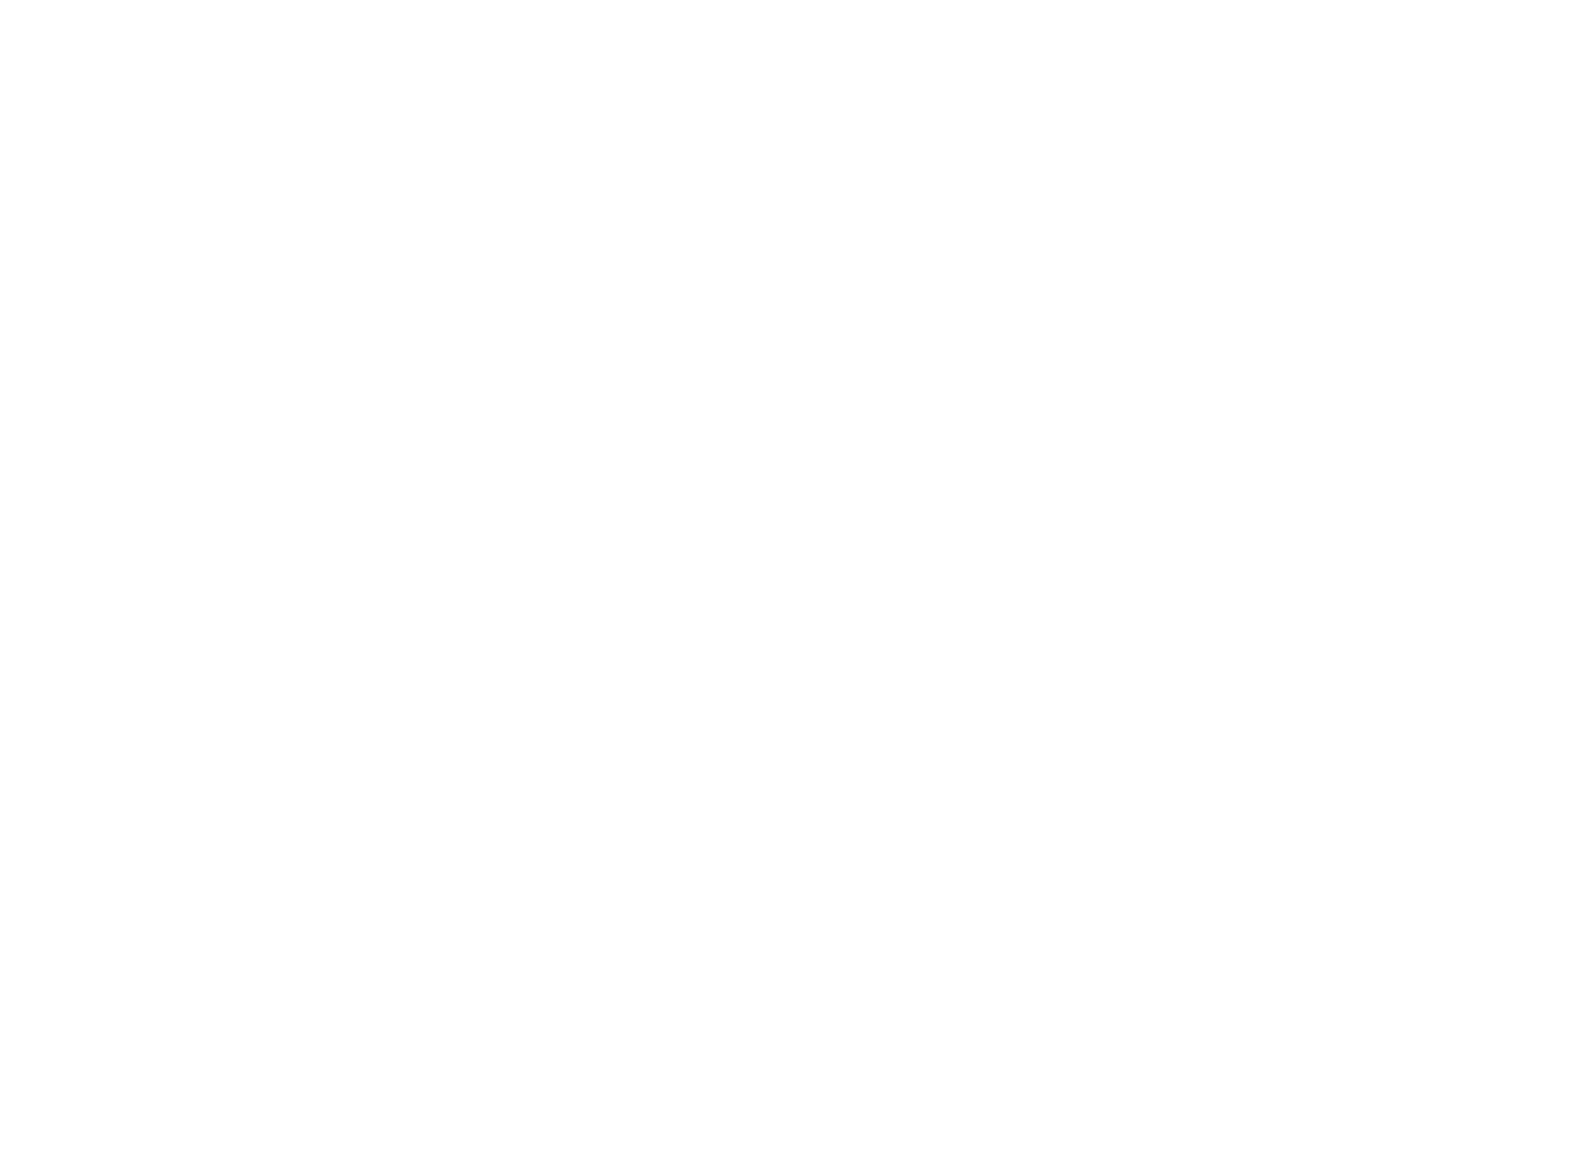

In [13]:
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'
name = '_muon_cut'

#make_true_histo_weight(cut + ' && TrackMomMCS_mom!=-1','p_per','EventWeight','Momentum perpendicular',0,2,20,'p_per_true'+name,'right')

for i in range(10):
    cut_i = cut+' && abs(p_para-0.05-0.1*'+str(i)+')<0.05'
    make_true_histo_weight(cut_i + ' && TrackMomMCS_mom!=-1','p_per','EventWeight','Momentum perpendicular',0,2,20,'p_per_true'+name+str(i),'right')
#NuCC_w.make_stacked_histo_weightV2(cut + ' && TrackMomMCS_mom!=-1','p_per','EventWeight','Momentum parallel',0,2,20,'p_per'+name,'right')

'''
start = time.time()
NuCC_w.make_stacked_histo_weightV2(cut + ' && TrackTheta!=-9','cos(TrackTheta)','EventWeight','cos(theta)',-1,1,20,'costhetaw'+name,'left')
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weightV2(cut + ' && TrackTheta!=-9','TrackPhi','EventWeight','Track Phi',-3.141,3.141,20,'phi'+name,'left')
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weightV2(cut + ' && 1','TrackMomMCS_mom','EventWeight','TrackMomMCS_mom',0,1.5,20,'TrackMomMCS_mom'+name)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weightV2(cut,'Nu_Vx_sce','EventWeight','Reco. Nu vertex X position [cm]',-10,270,20,'NuVx_sce'+name)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weightV2(cut,'Nu_Vy_sce','EventWeight','Reco. Nu vertex Y position [cm]',-120,120,20,'NuVy_sce'+name)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weightV2(cut,'Nu_Vz_sce','EventWeight','Reco. Nu vertex Z position [cm]',-50,1050,20,'NuVz_sce'+name)
end = time.time()
print(end - start)
'''

In [14]:
'''
std_all = {}
std_all[0] = np.load('/home/tmettler/Desktop/external_machines/pc46/numuCC/V35_weighted/all_genie/'+'theta_20bin_all.npy')
for j in range(len(std_all)):
    xbin = 20
    summe = 0.0
    for i in range(xbin):
        summe = summe + std_all[j][i]*std_all[j][i]
    print 'variable: ',j
    print math.sqrt(summe)*globale.scale[globale.overlay]/(1446.0)*100,'%'
    

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-14-8a2be3557b65>, line 11)

In [ ]:
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'
name = '_muon_cut_test'
#NuCC_w.make_stacked_histo_sys(cut + ' && TrackTheta!=-9','cos(TrackTheta)','EventWeight','cos(theta)',-1,1,20,'costhetaw'+name,'left',std_all[0])
